In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)



In [2]:
df = pd.read_parquet('ecom_sample_clean.parquet')
df.head()

,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.85
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.85
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.85
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.85
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.51


In [3]:
df.shape

(298222, 7)

In [4]:
df['Description'].value_counts()

REGENCY CAKESTAND 3 TIER               584
ROUND SNACK BOXES SET OF4 WOODLAND     494
PACK OF 72 RETROSPOT CAKE CASES        473
LUNCH BAG RED RETROSPOT                459
SPACEBOY LUNCH BOX                     455
                                      ... 
VINTAGE BLUE TINSEL REEL                 1
SET 10 CARDS CHRISTMAS BAUBLE 16954      1
PINK CRYSTAL GUITAR PHONE CHARM          1
WHITE DOVE HONEYCOMB PAPER GARLAND       1
PINK/WHITE GLASS DEMI CHOKER             1
Name: Description, Length: 3788, dtype: int64

<AxesSubplot:label='e0db8cb3-e5db-4fdf-868b-cbc3da9e4c68'>

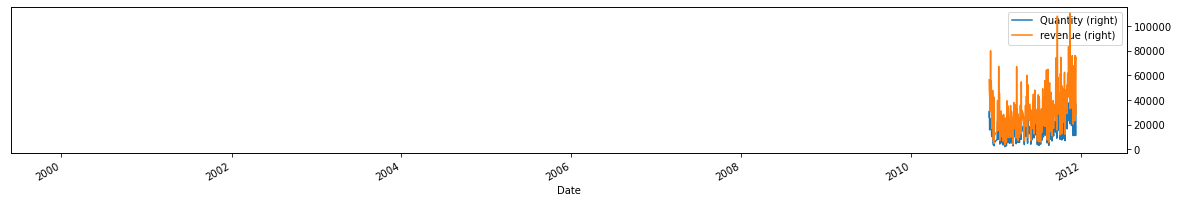

In [5]:
df.groupby('Date').agg(
    {
        'Quantity': 'sum',
        'revenue': 'sum',
    }
).plot(secondary_y=True,figsize=(20,3))

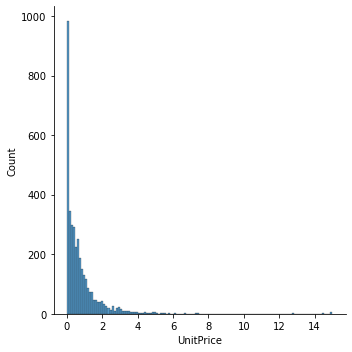

In [6]:
sns.displot(df.groupby('StockCode')['UnitPrice'].std().dropna().clip(0, 15), kde=False)

In [7]:
df_mdl = df[
    df.groupby('StockCode')['UnitPrice'].transform('std') > 0
]
print(df_mdl.shape)
del df

(294575, 7)


In [8]:
df_mdl = df_mdl.assign(
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

## 1. Naive Analysis First

In [9]:
df_mdl[['LnP', 'LnQ']].cov()

,LnP,LnQ
LnP,0.90431,-0.526940
LnQ,-0.52694,1.816541


In [51]:
import statsmodels.api as sm

def binned_ols(df, x, y, n_bins, plot=True, plot_title='', plot_ax=None, **plt_kwargs):

    x_bin = x + '_bin'
    df[x_bin] = pd.qcut(df[x], n_bins)

    tmp = df.groupby(x_bin).agg(
        {
            x: 'mean',
            y: 'mean',
        }
    )

    if plot:
        tmp.plot(x, y, figsize=(20,6), title=plot_title, ax=plot_ax, **plt_kwargs)
    
    del df[x_bin]

    mdl = sm.OLS(endog = tmp[y], exog = sm.add_constant(tmp[x]))
    res = mdl.fit()

    return res


                            OLS Regression Results                            
Dep. Variable:                    LnQ   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     50.31
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           8.13e-06
Time:                        08:56:47   Log-Likelihood:                -2.4962
No. Observations:                  15   AIC:                             8.992
Df Residuals:                      13   BIC:                             10.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3614      0.102     23.070      0.0

/Users/kai/anaconda3/envs/double_ml_demand_elasticity/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


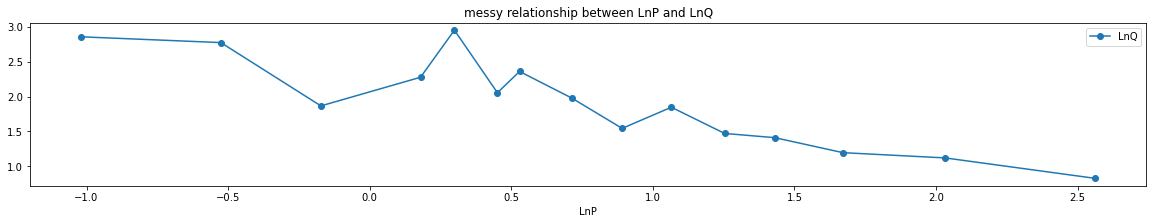

In [11]:
ols_fit = binned_ols(
    df = df_mdl,
    x = 'LnP',
    y = 'LnQ',
    n_bins = 15,
    plot_title = 'messy relationship between LnP and LnQ',
    marker = 'o'
)
print(ols_fit.summary())

## 2. Standard Econometrics-Style Causal Model

In [12]:
df_mdl.head()

,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice,LnP,LnQ
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.85,-0.162519,3.871201
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.85,-0.162519,2.484907
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.85,-0.162519,0.693147
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.85,-0.162519,1.609438
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.51,0.920283,0.000000


In [13]:
import sklearn.preprocessing
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor

feature_generator_basic = ColumnTransformer(
    [
        ('StockCode', OneHotEncoder(), ['StockCode']),
        ('Date', OneHotEncoder(), ['Date']),
        ('Country', OneHotEncoder(), ['Country']),
        ('LnP', 'passthrough', ['LnP']),
    ],
    remainder='drop',
)



In [14]:
mdl_basic = Pipeline(
    [
        ('feat_proc', feature_generator_basic),
        ('reg', linear_model.PoissonRegressor(
            alpha=1e-6, # L2 penalty
            fit_intercept=False,
            max_iter=100_000,
        )),
    ],
    verbose=True,
)

mdl_basic.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']],
    df_mdl['Quantity'], # Poisson regression has log-link. so LnQ is implicit in loss function
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing reg, total=  51.1s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 PoissonRegressor(alpha=1e-06, fit_intercept=False,
                                  max_iter=100000))],
         verbose=True)

In [15]:
mdl_basic_ols = Pipeline(
    [
        ('feat_proc', feature_generator_basic),
        ('reg', linear_model.Ridge(
            alpha=1e-10, # l2 penalty, very small
            fit_intercept=False,
            max_iter=100_000,
        ))
    ],
    verbose=True,
)

mdl_basic_ols.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']],
    df_mdl['LnQ'],
)


[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.1s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 Ridge(alpha=1e-10, fit_intercept=False, max_iter=100000))],
         verbose=True)

In [16]:
coef = pd.DataFrame({
    'feat': mdl_basic['feat_proc'].get_feature_names(),
    'coef': mdl_basic['reg'].coef_,
})
coef

,feat,coef
0,StockCode__x0_10002,-1.443015
1,StockCode__x0_10080,-4.079989
2,StockCode__x0_10120,-6.488823
3,StockCode__x0_10124G,-5.167688
4,StockCode__x0_10125,-2.016825
...,...,...
3704,Country__x0_USA,2.859267
3705,Country__x0_United Arab Emirates,2.981879
3706,Country__x0_United Kingdom,3.540613
3707,Country__x0_Unspecified,2.294314


In [17]:
pd.DataFrame({
    'feat': mdl_basic_ols['feat_proc'].get_feature_names(),
    'coef': mdl_basic_ols['reg'].coef_,
})

,feat,coef
0,StockCode__x0_10002,-0.935992
1,StockCode__x0_10080,-1.939307
2,StockCode__x0_10120,-4.221674
3,StockCode__x0_10124G,-1.515776
4,StockCode__x0_10125,-1.049512
...,...,...
3704,Country__x0_USA,2.267349
3705,Country__x0_United Arab Emirates,2.451372
3706,Country__x0_United Kingdom,2.420195
3707,Country__x0_Unspecified,1.655168


<AxesSubplot:title={'center':'Date fixed effects track (avg) sales, but not perfectly: deviation is explained by large effect of individual items'}, xlabel='Date'>

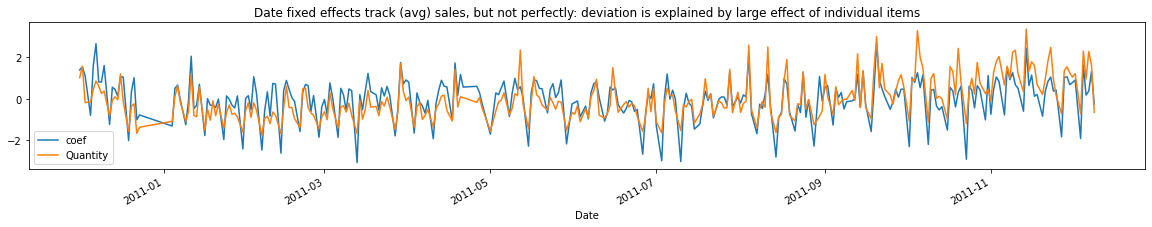

In [18]:
(
    pd.concat(
        [
            coef[coef.feat.str.startswith('Date')].reset_index(drop=True),
            df_mdl.groupby('Date')['Quantity'].sum().reset_index()
        ],
        axis=1,
    )
    .set_index('Date')
    .drop(['feat'], axis=1)
    .pipe(
        lambda d: (d-d.mean())/d.std()
    )
).plot(
    figsize=(20,3),
    title='Date fixed effects track (avg) sales, but not perfectly: deviation is explained by large effect of individual items'
)


## 3. double-ML by hand

Step 0: 
Demand price within item, (equivalent to adding an item-level fixed effect)
$$
dLnP_{i,t} = log(p_{i,t}) - log(\bar{p}_i)
$$
$$
dLnQ_{i,t} = log(q_{i,t}) - log(\bar{q}_i)
$$ 

In [19]:
df_mdl['dLnP'] = np.log(df_mdl['UnitPrice']) - np.log(df_mdl.groupby('StockCode')['UnitPrice'].transform('mean'))
df_mdl['dLnQ'] = np.log(df_mdl['Quantity']) - np.log(df_mdl.groupby('StockCode')['Quantity'].transform('mean'))

In [20]:
df_mdl[['dLnP', 'dLnQ']].cov()

,dLnP,dLnQ
dLnP,0.069442,-0.122739
dLnQ,-0.122739,1.274948


In [21]:
df_mdl = df_mdl.assign(
    month = lambda d: d['Date'].dt.month,
    DoM = lambda d: d['Date'].dt.day,
    DoW = lambda d: d['Date'].dt.weekday,
    stock_age_days = lambda d: (d['Date'] - d.groupby('StockCode')['Date'].transform('min')).dt.days,
    sku_avg_p = lambda d: d.groupby('StockCode')['UnitPrice'].transform('median')
)

Step 1: auxiliary model to orthogonalize P and Q

In [40]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [60]:
feature_generator_full = ColumnTransformer(
    [
        ('Date', OneHotEncoder(), ['Date']),
        ('Description', CountVectorizer(min_df=0.0025, ngram_range=(1, 3)), 'Description'),
        ('Country', OneHotEncoder(), ['Country']),
        ('numeric_feats', StandardScaler(), ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p'])
    ],
    remainder='drop',
)

xgb_hyperparameters = dict(n_estimators=20, max_depth=10, alpha=0.1, colsample_bynode=0.5)

model_p = Pipeline(
    [
        ('feat_proc', feature_generator_full),
        # ('model_p', RandomForestRegressor(n_estimators=50, min_samples_leaf=3)) 
        ('model_p', XGBRegressor(**xgb_hyperparameters)) 
    ]
)

model_q = Pipeline(
    [
        ('feat_proc', feature_generator_full),
        # ('model_q', RandomForestRegressor(n_estimators=50, min_samples_leaf=3)) 
        ('model_q', XGBRegressor(**xgb_hyperparameters)) 
    ]
)


In [61]:

model_p.fit(df_mdl, df_mdl.dLnP)
model_q.fit(df_mdl, df_mdl.dLnP)

Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Description',
                                                  CountVectorizer(min_df=0.0025,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'Description'),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('numeric_feats',
                                                  StandardScaler(),
                                                  ['month', 'DoM', 'DoW',
                                                   'stock_age_days',
                                    

In [71]:
feature_generator_full = ColumnTransformer(
    [
        ('Date', OneHotEncoder(), ['Date']),
        ('Description', CountVectorizer(min_df=0.0025, ngram_range=(1, 3)), 'Description'),
        ('Country', OneHotEncoder(), ['Country']),
        ('numeric_feats', StandardScaler(), ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p'])
    ],
    remainder='drop',
)


model_p = Pipeline(
    [
        ('feat_proc', feature_generator_full),
        ('model_p', XGBRegressor()) 
    ]
)

model_q = Pipeline(
    [
        ('feat_proc', feature_generator_full),
        ('model_q', XGBRegressor()) 
    ]
)



from sklearn.model_selection import RandomizedSearchCV


params_p = {
    'model_p__n_estimators': [20, 50, 100],
    'model_p__max_depth': [2, 5, 10],
    'model_p__learning_rate': [0.01, 0.1],
    'model_p__alpha': [0, 0.1, 1],
}
rand_p = RandomizedSearchCV(
    model_p,
    params_p,
    cv=5,
    random_state=1,
)
rand_p.fit(
    df_mdl,
    df_mdl['dLnP']
)
model_p = rand_p.best_estimator_





params_q = {
    'model_q__n_estimators': [20, 50, 100],
    'model_q__max_depth': [2, 5, 10],
    'model_q__learning_rate': [0.01, 0.1],
    'model_q__alpha': [0, 0.1, 1],
}
rand_q = RandomizedSearchCV(
    model_q,
    params_q,
    cv=5,
    random_state=1,
)
rand_q.fit(
    df_mdl,
    df_mdl['dLnP']
)
model_q = rand_q.best_estimator_


/Users/kai/anaconda3/envs/double_ml_demand_elasticity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kai/anaconda3/envs/double_ml_demand_elasticity/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/kai/anaconda3/envs/double_ml_demand_elasticity/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/kai/anaconda3/envs/double_ml_demand_elasticity/lib/python3.9/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/kai/anaconda3/envs/double_ml_demand_elasticity/lib/python3.9/site-packages/sklearn/pipeline.py", line

In [74]:
q_hat = model_q.predict(df_mdl)
p_hat = model_p.predict(df_mdl)

df_mdl = df_mdl.assign(
    dLnP_res = df_mdl['dLnP'] - p_hat,
    dLnQ_res = df_mdl['dLnQ'] - q_hat,
)


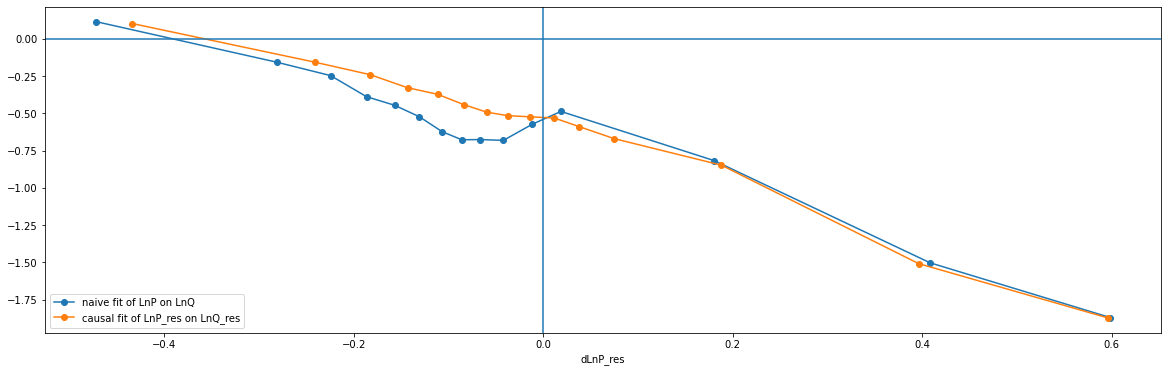

In [75]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    label='naive fit of LnP on LnQ',
    marker='o',
)

new_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    label='causal fit of LnP_res on LnQ_res',
    plot_ax=plt.gca(),
    marker='o',
)

plt.gca().axvline(0)
plt.gca().axhline(0)

In [76]:
def get_feat_generator_names(gen):
    res = []
    for i, (k, t) in enumerate(gen.named_transformers_.items()):
        if k == 'remainder':
            continue
        try:
            res += [f'{k}_{n}' for n in t.get_feature_names()]
        except:
            res += list(gen.transformers_[i][2])
    return res

<AxesSubplot:ylabel='feat'>

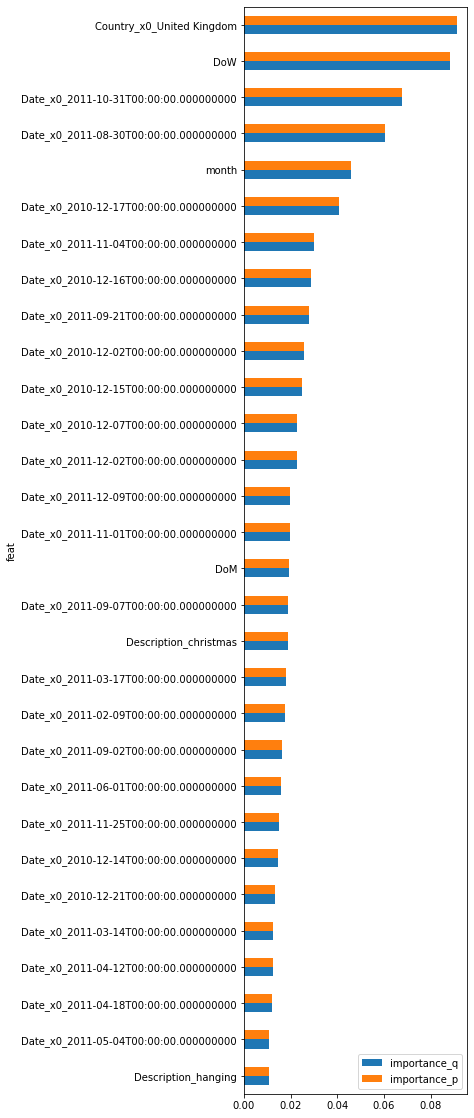

In [77]:
feat_imp = pd.DataFrame(
    {
        'feat': get_feat_generator_names(model_p['feat_proc']),
        'importance_q': model_q['model_q'].feature_importances_,
        'importance_p': model_p['model_p'].feature_importances_,
    }
).set_index('feat')

feat_imp.sort_values(by='importance_p').iloc[-30:].plot(kind='barh', figsize=(4, 20))

## 4. Use Double-ML Directly